In [41]:
import torch as th
import numpy as np

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt

# set random seed
np.random.seed(333)
th.manual_seed(333)
th.cuda.manual_seed(333)
th.backends.cudnn.deterministic = True


BW = 20 * 1e6 # Bandwidth in bits per second
FPS = 10
PSZ = 4 * 16 # 4 channels of 16 bits each

NUM_POINTS = 480 * 480 # Number of points in the point cloud

D_Guaranteed = 3 # meters
D_exponent = 7
 # exponent for the validity function


MFS = BW/FPS # Maximum Frame Size in bits

MAX_POINTS = int(np.min([MFS/PSZ, NUM_POINTS])) # Maximum number of points in the point cloud


# a tensor 480x480x4  pxl, pxl,(x,y,z,validity)
points = th.rand(480, 480, 4)*20



# read points from ../dataset/pointclouds/local.ply

points = th.from_numpy(np.loadtxt("work/pcls/local1.ply", skiprows=11, delimiter=" ", usecols=(0,1,2,3), max_rows=NUM_POINTS)).float()

## change the sign of z values

points[:,2] = -points[:,2]



tic = th.cuda.Event(enable_timing=True)
toc = th.cuda.Event(enable_timing=True)


points = points.view(-1, 4).contiguous()

print("points shape: ", points.shape)

############################# CLASSIC DIANE

tic.record()

diane_validity = 1/(points[:,2]/th.max(points[:,2]) + 1e-6)**D_exponent

print("max validity: ", th.max(diane_validity))

diane_validity[points[:,2] < D_Guaranteed] = th.max(diane_validity)

valid_classic_diane_indexes = th.multinomial(diane_validity, MAX_POINTS, replacement=False)
valid_classic_diane_points = points[valid_classic_diane_indexes]

toc.record()
th.cuda.synchronize()

time_classic_diane = tic.elapsed_time(toc)
print("elapsed time classic diane: ", time_classic_diane, "ms")


frame_size = PSZ * valid_classic_diane_points.size(0)






points shape:  torch.Size([230400, 4])
max validity:  tensor(6131.6924)
elapsed time classic diane:  4.61516809463501 ms


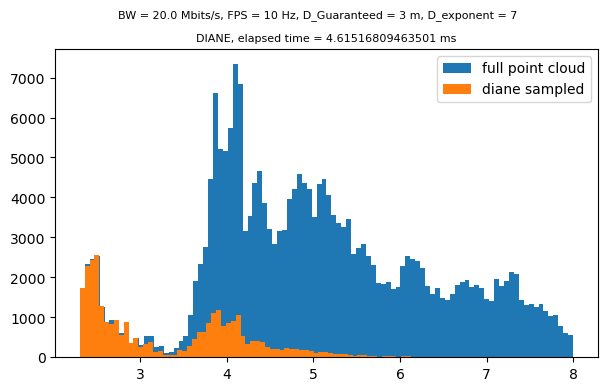

grabbed point cloud has 230400 points
to transmit it would be required a bandwidth of 147.456 Mbits/s
with a BW of 20.0 Mbits/s and FPS of 10 the maximum number of points that can be transmitted is 31250.0
points selected for transmission 31250


In [42]:
sample = valid_classic_diane_points[th.randint(0, valid_classic_diane_points.size(0), (1,))]

#print(valid_classic_diane_points)




# print cdf on z for original and sampled point cloud

# plot with size of plot 5x2
# subplots 3x1
BINS_FOR_PLOT = 100

plt.figure(figsize=(7, 4))

plt.suptitle("BW = "+str(BW/1e6)+" Mbits/s, FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed)+" m, D_exponent = "+str(D_exponent), fontsize=8)
plt.title("DIANE, elapsed time = "+str(time_classic_diane)+" ms", fontsize=8)
plt.hist(points[:,2].numpy(), bins=BINS_FOR_PLOT, alpha=1, label='full point cloud')
plt.hist(valid_classic_diane_points[:,2].numpy(), bins=BINS_FOR_PLOT, alpha=1, label='diane sampled')
plt.legend(loc='upper right')


# # finer ticks
# plt.xticks(np.arange(0, 20, 1))


plt.show()



print("grabbed point cloud has", NUM_POINTS, "points")
print("to transmit it would be required a bandwidth of", NUM_POINTS*PSZ*FPS/1000000, "Mbits/s")

print("with a BW of", BW/1e6, "Mbits/s and FPS of", FPS, "the maximum number of points that can be transmitted is", MFS/PSZ)

print("points selected for transmission", valid_classic_diane_points.size(0))


